In [17]:
import numpy as np
import random
import time
import pdb
import unittest
from PIL import Image
import math
import matplotlib.pyplot as plt
import matplotlib.image as pimg

In [18]:
def l1(u, v):
  # Finds the L1 distance between two vectors
  # u and v are 1-dimensional np.array objects
  # TODO: Implement this
  return np.sum(np.abs(u - v))

In [19]:
def load_data(filename):
  # Loads the data into a np array, where each row corresponds to
  # an image patch -- this step is sort of slow.
  # Each row in the data is an image, and there are 400 columns.
  return np.genfromtxt(filename, dtype= None, delimiter = ',', skip_footer = 1)

In [20]:
def create_function(dimensions, thresholds):
  # Creates a hash function from a list of dimensions and thresholds.
  def f(v):
    boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
    return "".join(map(str, map(int, boolarray)))
  return f

In [21]:
# Creates the LSH functions (functions that compute L K-bit hash keys).
# Each function selects k dimensions (i.e. column indices of the image matrix)
# at random, and then chooses a random threshold for each dimension, between 0 and
# 255.  For any image, if its value on a given dimension is greater than or equal to
# the randomly chosen threshold, we set that bit to 1.  Each hash function returns
# a length-k bit string of the form "0101010001101001...", and the L hash functions 
# will produce L such bit strings for each image.
def create_functions(k, L, num_dimensions = 400, min_threshold = 0, max_threshold = 255):
  functions = []
  for i in range(L):
    dimensions = np.random.randint(low = 0,
                                   high = num_dimensions,
                                   size = k)
    thresholds = np.random.randint(low = min_threshold,
                                   high = max_threshold + 1,
                                   size = k)
    functions.append(create_function(dimensions, thresholds))
  return functions

In [22]:
# 하나의 shingling에 대한 hash_vector 추출
def hash_vector(functions, v):
    # Hashes an individual vector (i.e. image).  This produces an array with L
    # entries, where each entry is a string of k bits.
    return np.array([f(v) for f in functions])

In [23]:
def hash_data(functions, A):
    # Hashes the data in A, where each row is a datapoint, using the L
    # functions in "functions."
    return np.array(list(map(lambda v: hash_vector(functions, v), A)))

In [24]:
# Retrieve all of the points that hash to one of the same buckets 
# as the query point.  Do not do any random sampling (unlike what the first
# part of this problem prescribes).
# Don't retrieve a point if it is the same point as the query point.
def get_candidates(hashed_A, hashed_point, query_index):
  return filter(lambda i:i != query_index and \
                any(hashed_point == hashed_A[i]), range(len(hashed_A)))

In [25]:
# Sets up the LSH.  You should try to call this function as few times as 
# possible, since it is expensive.
# A: The dataset.
# Return the LSH functions and hashed data structure.
def lsh_setup(A, k = 24, L = 10):
  functions = create_functions(k = k, L = L)
  hashed_A = hash_data(functions, A)
  return (functions, hashed_A)

In [26]:
# Run the entire LSH algorithm
def lsh_search(A, hashed_A, functions, query_index, num_neighbors = 10):
    hashed_point = hash_vector(functions, A[query_index, :])
    candidate_row_nums = get_candidates(hashed_A, hashed_point, query_index)
    
    distances = map(lambda r: (r, l1(A[r], A[query_index])), candidate_row_nums)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]

    return [t[0] for t in best_neighbors]

In [27]:
# Plots images at the specified rows and saves them each to files.
def plot(A, row_nums, base_filename):
  for row_num in row_nums:
    patch = np.reshape(A[row_num, :], [20, 20])
    im = Image.fromaaray(patch)
    if im.mode != 'RGB':
      im = im.convert('RGB')
    im.save(base_filename + "-" + str(row_num) + ".png")

In [28]:
# Finds the nearest neighbors to a given vector, using linear search.
def linear_search(A, query_index, num_neighbors):
  all_neighbors = filter(lambda i: i != query_index, range(len(A)))
  distances = map(lambda r: (r, l1(A[r], A[query_index])), all_neighbors)
  best_neighbors = sorted(distances, key = lambda t: t[1])[:num_neighbors]

  return [t[0] for t in best_neighbors]

In [29]:
# TODO: Write a function that computes the error measure
def error(A, k, L, indexes, nearestN):
  functions, hashed_A = lsh_setup(A, k, L)
  errors = []
  for query_index in indexes:
    lsh_nearests = lsh_search(A, hashed_A, functions, query_index, nearestN)
    ann_l1_dists = map(lambda r: l1(A[r], A[query_index]), lsh_nearests)
    ann_dist_sum = math.fsum(ann_l1_dists)
    lin_nearests = linear_search(A, query_index, nearestN)
    lin_l1_dists = map(lambda r: l1(A[r], A[query_index]), lin_nearests)
    lin_dist_sum = math.fsum(lin_l1_dists)
    errors.append((1.0 * ann_dist_sum) / lin_dist_sum)
  return np.mean(errors)

In [30]:
def plot_fig(xlabel, Xs, ylabel, Ys, color, title, legend, filename = None):
  plt.figure(figsize = (12, 6))
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.plot(Xs, Ys, color, label = legend)
  plt.legend(loc = "lower right")
  if filename:
    plt.savefig(filename)
    plt.close(filename)
  else:
    plt.show()

In [31]:
def plot_sideByside(As, qImage, nImages, subtitle, h, w, n_row = 3, n_col = 5, filename = None):
  nbrCnt = len(nImages)
  images = np.empty((nbrCnt + 1, 20, 20))
  titles = ["" for i in range(nbrCnt + 1)]

  for i in range(nbrCnt):
    img = np.reshape(As[nImages[i], :], [20, 20])
    images[i,:,:] = img
    titles[i] = "near neighbor #" + str(i) + ", index: " + str(nImages[i]) + " - " + subtitle

  images[nbrCnt, :, :] = np.reshape(As[qImage, :], [20, 20])
  titles[nbrCnt] = "Query image, index" + str(qImage)

  plt.figure(figsize = (1.5 * n_col, 1.8 * n_row))
  plt.subplots_adjust(bottom = 0, left = .01, right = .99, top = .90, hspace = .35)
  llen = 18
  for i in range(min(n_row * n_col, len(images))):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i])
    title_i = titles[i]
    if len(title_i) >= llen:
      title_i = titles[i][:llen] + '\n' + titles[i][llen:]
    plt.title(title_i, size = 7)
    plt.xticks(())
    plt.yticks(())

  if filename:
    plt.savefig(filename)
    plt.close()
  else:
    plt.show()

In [43]:
import time
#    A= load_data('data/patches.csv')
#    functions, hashed_A = lsh_setup(A)
#    query_index= 100
#    lsh_result =  lsh_search(A, hashed_A, functions, query_index, num_neighbors = 10)
#    linear_result =  linear_search( A,query_index,num_neighbors=10)
#    plot(A,lsh_result,'LSH')
#    plot(A,linear_result,'LINEAR')  
#    plot(A,[100],'RAW')
def problem4():
  # As = load_data('./drive/MyDrive/patches.csv')
  As = load_data('/home/ljj0512/private/workspace/data-mining/06_locally-sensitive-hashing/patches.csv')

  Qs = [100*i-1 for i in range(1, 11)]

  funcs, hAs = lsh_setup(As)
  Ts_lsh = []
  Ts_lin = []

  top3n_lsh = []
  top3n_lin = []

  for query_index in Qs:
    start = time.time()
    lsh_result = lsh_search(As, hAs, funcs, query_index, num_neighbors=10)
    Ts_lsh.append((time.time()-start)*1000)
    top3n_lsh.append((query_index, lsh_result[:3]))

    start = time.time()
    linear_result =  linear_search(As, query_index, num_neighbors=10)
    Ts_lin.append((time.time()-start)*1000)
    top3n_lin.append((query_index, linear_result[:3]))

  print("LSH search: (query_index, [top 3 near neighbors]):")
  for p in top3n_lsh:
    print(p)

  print()

  print("Linear search: (query_index, [top 3 near neighbors]):")
  for p in top3n_lin:
    print(p)

  print()

  meanStime_lsh = np.array(Ts_lsh).mean()
  meanStime_linear = np.array(Ts_lin).mean()
  print("Average Top 3 nearest neighbors LSH searching time: %0.3f (ms)" % (meanStime_lsh))
  print("Average Top 3 nearest neighbors Linear search time: %0.3f (ms)" % (meanStime_linear))

  print()

  k = 24
  Ls = [10, 12, 14, 16, 18, 20]
  ks = [16, 18, 20, 22, 24]
  L = 10

  err_kLs = []
  err_ksL = []

  for Li in Ls:
    err_kLs.append(error(As, k, L, Qs, Li))
  plot_fig("X axis - L values", Ls, "Y axis - Errors (k = 24)", err_kLs, "bs-", "Error vs. L (10, 12, 14, 16, 18, 20)", "k = 24", "error-L.png")

  for ki in ks:
    err_ksL.append(error(As, k, L, Qs, ki))
  plot_fig('X axis - k values', ks, 'Y axis - Errors (L = 10)', err_ksL, 'g^-', 'Errors vs. k (16,18,20,22,24)', 'L = 10', 'error-k.png')

  query_index = 99
  topN = 10

  funcs, hAs = lsh_setup(As)

  nbs = lsh_search(As, hAs, funcs, query_index, topN)
  plot_sideByside(As, query_index, nbs, "LSH", 40, 40, n_row = 3, n_col = 5, filename = "LSH-Top10.png")

  nbs = linear_search(As, query_index, topN)
  plot_sideByside(As, query_index, nbs, "Linear", 40, 40, n_row = 3, n_col = 5, filename = "Linear-Top10.png")

In [34]:
class TestLSH(unittest.TestCase):
  def test_l1(self):
    u = np.array([1, 2, 3, 4])
    v = np.array([2, 3, 2, 3])
    self.assertEqual(l1(u, v), 4)

  def test_hash_data(self):
    f1 = lambda v: sum(v)
    f2 = lambda v: sum([x * x for x in v])
    A = np.array([1, 2, 3], [4, 5, 6])
    self.assertEqual(f1(A[0, :]), 6)
    self.assertEqual(f2(A[0, :]), 14)

    functions = [f1, f2]
    self.assertTrue(np.array_equal(hash_vector(functions, A[0, :]), np.array([6, 14])))
    self.assertTrue(np.array_equal(hash_data(functions, A), np.array([[6, 4], [15, 77]])))

  def test_plot_fig(self):
    Epoch = [1,2,3,4,5,6,7,8,9]
    y = [0.1, 0.15, 0.05, 0.11, 0.16, 0.09, 0.11, 0.15, 0.16]
    plot_fig("x-epoch", Epoch, "y-accuracy", y, "bs-", "Test plot", "test legend", "test-plot.png")


LSH search: (query_index, [top 3 near neighbors]):
(99, [37742, 11947, 42568])
(199, [53727, 56338, 36177])
(299, [51140, 23097, 8430])
(399, [19014, 31612, 40598])
(499, [56997, 47977, 8418])
(599, [6201, 59148, 43978])
(699, [50345, 31709, 40811])
(799, [24319, 58128, 13932])
(899, [34377, 41365, 38565])
(999, [28450, 59238, 28339])

Linear search: (query_index, [top 3 near neighbors]):
(99, [58690, 23633, 26168])
(199, [39397, 11341, 23895])
(299, [51140, 23097, 8430])
(399, [20536, 18874, 20572])
(499, [14552, 51717, 21520])
(599, [6201, 47784, 9540])
(699, [50345, 31709, 40811])
(799, [33741, 13889, 24319])
(899, [34377, 41365, 38565])
(999, [46093, 28450, 59238])

Average Top 3 nearest neighbors LSH searching time: 114.708 (ms)
Average Top 3 nearest neighbors Linear search time: 374.488 (ms)



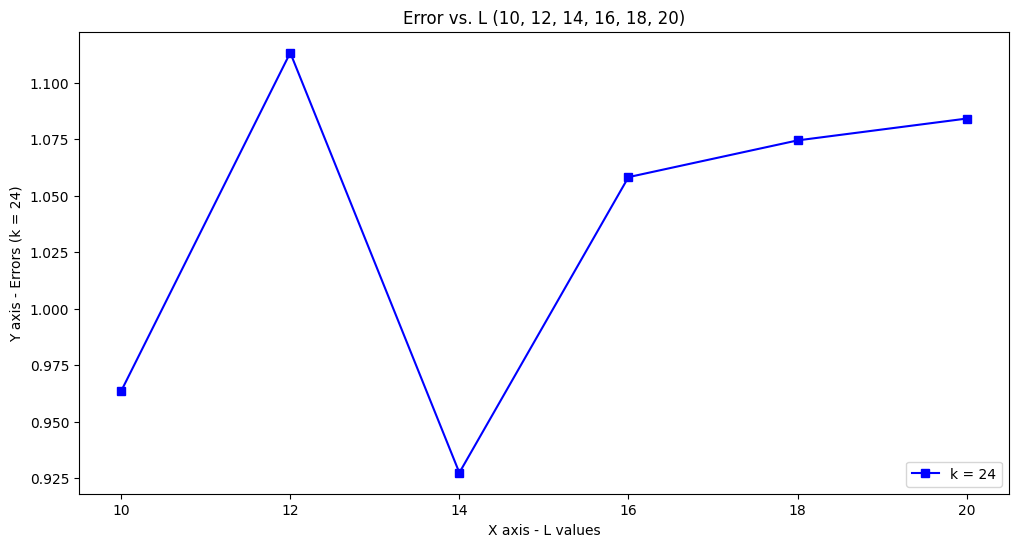

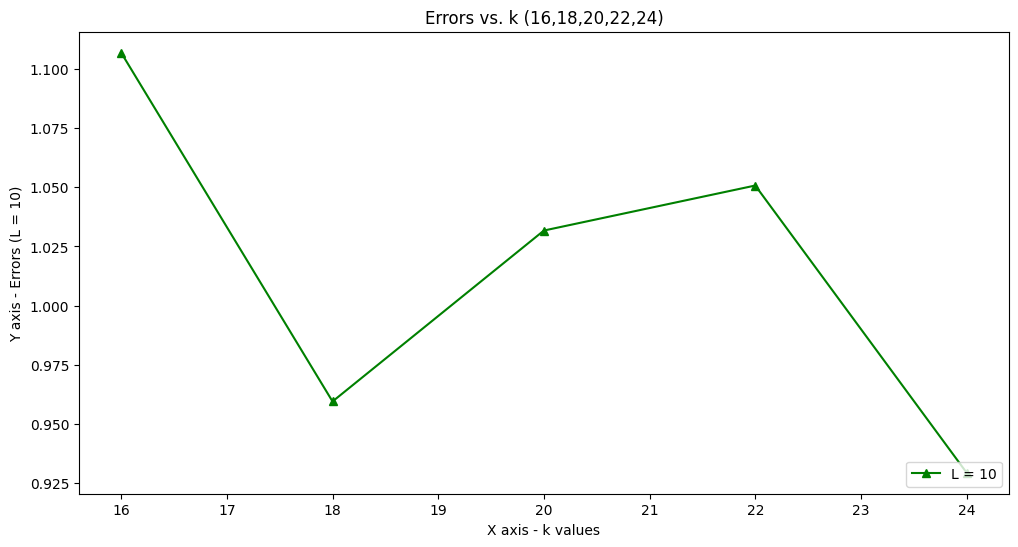

In [44]:
problem4()

LSH search: (query_index, [top 3 near neighbors]):
(99, [48596, 16149, 17800])
(199, [23550, 42060, 13594])
(299, [46635, 47437, 34225])
(399, [44271, 8595, 29885])
(499, [14614, 7514, 7743])
(599, [7270, 57186])
(699, [50345, 31709, 40811])
(799, [33741, 58128, 13360])
(899, [34377, 41365, 40958])
(999, [46093, 28450, 59238])

Linear search: (query_index, [top 3 near neighbors]):
(99, [58690, 23633, 26168])
(199, [39397, 11341, 23895])
(299, [51140, 23097, 8430])
(399, [20536, 18874, 20572])
(499, [14552, 51717, 21520])
(599, [6201, 47784, 9540])
(699, [50345, 31709, 40811])
(799, [33741, 13889, 24319])
(899, [34377, 41365, 38565])
(999, [46093, 28450, 59238])

Average Top 3 nearest neighbors LSH searching time: 0.110 (ms)
Average Top 3 nearest neighbors Linear search time: 0.388 (ms)



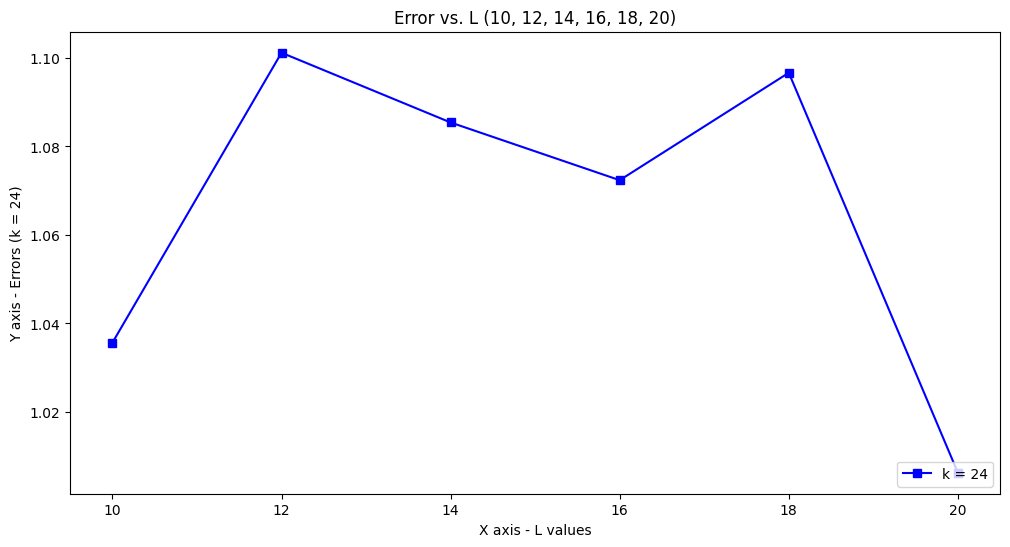

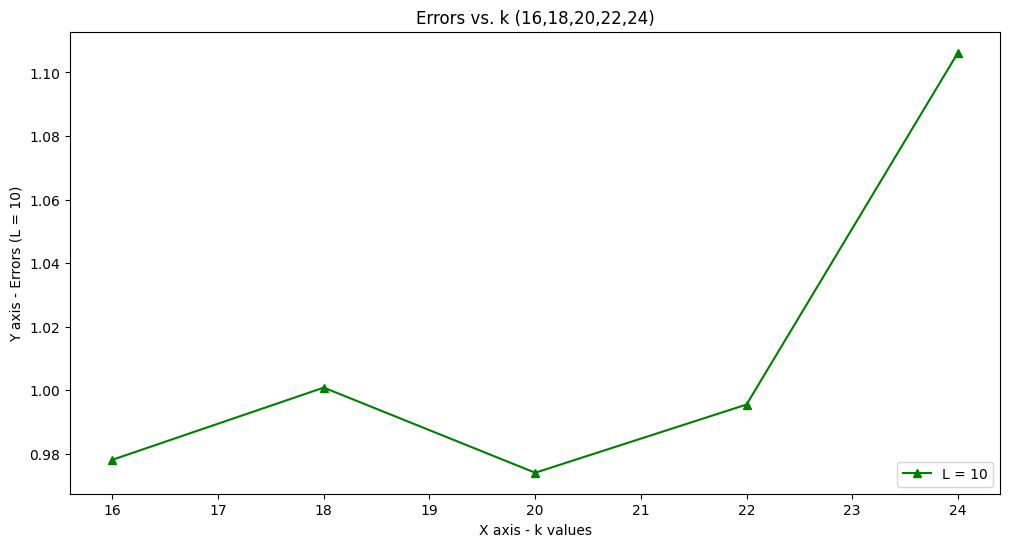

In [42]:
problem4()

LSH search: (query_index, [top 3 near neighbors]):
(99, [58690, 28054, 23843])
(199, [19604, 14773, 52548])
(299, [23097, 54507, 51447])
(399, [57819, 19558, 14566])
(499, [14552, 51717, 13472])
(599, [22957, 23640, 34138])
(699, [50345, 31709, 40811])
(799, [22766, 16560, 18236])
(899, [34377, 41365, 38565])
(999, [46093, 28450, 59238])

Linear search: (query_index, [top 3 near neighbors]):
(99, [58690, 23633, 26168])
(199, [39397, 11341, 23895])
(299, [51140, 23097, 8430])
(399, [20536, 18874, 20572])
(499, [14552, 51717, 21520])
(599, [6201, 47784, 9540])
(699, [50345, 31709, 40811])
(799, [33741, 13889, 24319])
(899, [34377, 41365, 38565])
(999, [46093, 28450, 59238])

Average Top 3 nearest neighbors LSH searching time: 160.336 (ms)
Average Top 3 nearest neighbors Linear search time: 528.265 (ms)



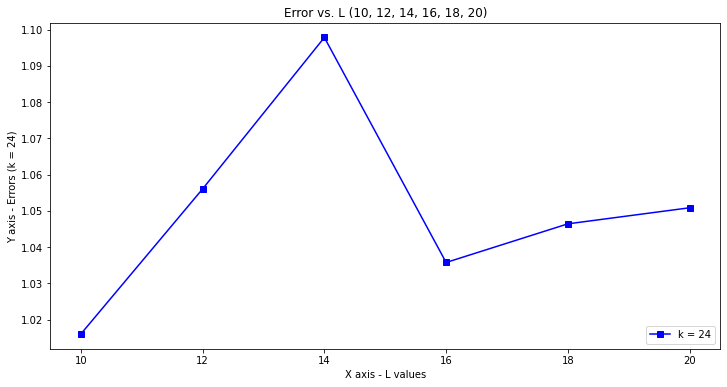

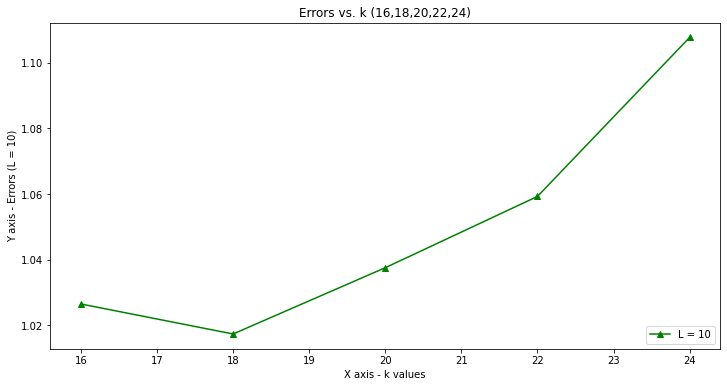

In [ ]:
problem4()